<a href="https://colab.research.google.com/github/aliakbarbadri/persian-poetry-creator/blob/master/word-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

# Data

In [0]:
url = "https://raw.githubusercontent.com/aliakbarbadri/persian-poetry-creator/master/shahname2.txt"
filepath = keras.utils.get_file("shahname.txt", url) 
with open(filepath) as f:
  data = f.read()
texts = data.split("\n")

In [18]:
beyt10 = "\n".join(texts[:20])
len(beyt10.split())

204

In [0]:
corpus = []
length = 20
for i in range(int(20000/length)):
  beyt10 = "\n".join(texts[i:i+length])
  corpus.append(beyt10)

In [20]:
len(corpus)

1000

In [21]:
corpus[0]

'چو ترکان بدیدند کارجاسپ رفت\tهمی آید از هر سوی تیغ تفت\nهمه سرکشانشان پیاده شدند\tبه پیش گو اسفندیار آمدند\nکمانچای چاچی بینداختند\tقبای نبردی برون آختند\nبه زاریش گفتند گر شهریار\tدهد بندگان را به جان زینهار\nبدین اندر آییم و خواهش کنیم\tهمه آذران را نیایش کنیم\nازیشان چو بشنید اسفندیار\tبه جان و به تن دادشان زینهار\nبران لشگر گشن آواز داد\tگو نامبردار فرخ\u200cنژاد\nکه این نامداران ایرانیان\tبگردید زین لشکر چینیان\nکنون کاین سپاه عدو گشت پست\tازین سهم و کشتن بدارید دست\nکه بس زاروارند و بیچاره\u200cوار\tدهدی این سگان را به جان زینهار\nبدارید دست از گرفتن کنون\tمبندید کس را مریزید خون\nمتازید و این کشتگان مسپرید\tبگردید و این خستگان بشمرید\nمگیریدشان بهر جان زریر\tبر اسپان جنگی مپایید دیر\nچو لشکر شنیدند آواز اوی\tشدند از بر خستگان بارزوی\nبه لشکرگه خود فرود آمدند\tبه پیروز گشتن تبیره زدند\nهمه شب نخفتند زان خرمی\tکه پیروزی بودشان رستمی\nچو اندر شکست آن شب تیره\u200cگون\tبه دشت و بیابان فرو خورد خون\nکی نامور با سران سپاه\tبیامد به دیدار آن رزمگاه\nهمی گرد آن کشتگان بر بگشت\tکرا دید 

In [22]:
print(corpus[0])

چو ترکان بدیدند کارجاسپ رفت	همی آید از هر سوی تیغ تفت
همه سرکشانشان پیاده شدند	به پیش گو اسفندیار آمدند
کمانچای چاچی بینداختند	قبای نبردی برون آختند
به زاریش گفتند گر شهریار	دهد بندگان را به جان زینهار
بدین اندر آییم و خواهش کنیم	همه آذران را نیایش کنیم
ازیشان چو بشنید اسفندیار	به جان و به تن دادشان زینهار
بران لشگر گشن آواز داد	گو نامبردار فرخ‌نژاد
که این نامداران ایرانیان	بگردید زین لشکر چینیان
کنون کاین سپاه عدو گشت پست	ازین سهم و کشتن بدارید دست
که بس زاروارند و بیچاره‌وار	دهدی این سگان را به جان زینهار
بدارید دست از گرفتن کنون	مبندید کس را مریزید خون
متازید و این کشتگان مسپرید	بگردید و این خستگان بشمرید
مگیریدشان بهر جان زریر	بر اسپان جنگی مپایید دیر
چو لشکر شنیدند آواز اوی	شدند از بر خستگان بارزوی
به لشکرگه خود فرود آمدند	به پیروز گشتن تبیره زدند
همه شب نخفتند زان خرمی	که پیروزی بودشان رستمی
چو اندر شکست آن شب تیره‌گون	به دشت و بیابان فرو خورد خون
کی نامور با سران سپاه	بیامد به دیدار آن رزمگاه
همی گرد آن کشتگان بر بگشت	کرا دید بگریست و اندر گذشت
برادرش را دید کشته به زار	به آوردگ

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
for k,v in enumerate(tokenizer.word_index):
  if '\t' in v:
    print(k)

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [0]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

# Model

In [9]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 254, 100)          273100    
_________________________________________________________________
bidirectional (Bidirectional (None, 254, 300)          301200    
_________________________________________________________________
dropout (Dropout)            (None, 254, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1365)              137865    
_________________________________________________________________
dense_1 (Dense)              (None, 2731)              3730546   
Total params: 4,603,111
Trainable params: 4,603,111
Non-trainable params: 0
______________________________________________

In [10]:
history = model.fit(predictors, label, epochs=15)

Epoch 1/20
6901/6901 [==============================] - 300s 43ms/step - loss: 6.3005 - accuracy: 0.0405
Epoch 2/20
6901/6901 [==============================] - 288s 42ms/step - loss: 5.5855 - accuracy: 0.0709
Epoch 3/20
6901/6901 [==============================] - 285s 41ms/step - loss: 4.8181 - accuracy: 0.1307
Epoch 4/20
6901/6901 [==============================] - 288s 42ms/step - loss: 4.0280 - accuracy: 0.2227
Epoch 5/20
6901/6901 [==============================] - 291s 42ms/step - loss: 3.3195 - accuracy: 0.3445
Epoch 6/20
6901/6901 [==============================] - 290s 42ms/step - loss: 2.7245 - accuracy: 0.4682
Epoch 7/20
6901/6901 [==============================] - 290s 42ms/step - loss: 2.2247 - accuracy: 0.5816
Epoch 8/20
6901/6901 [==============================] - 288s 42ms/step - loss: 1.8256 - accuracy: 0.6719
Epoch 9/20
6901/6901 [==============================] - 289s 42ms/step - loss: 1.5168 - accuracy: 0.7400
Epoch 10/20
6901/6901 [==============================] 

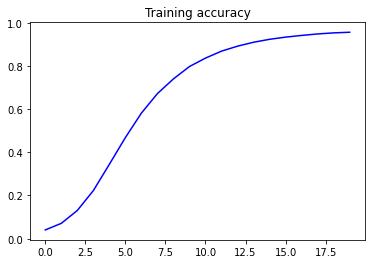

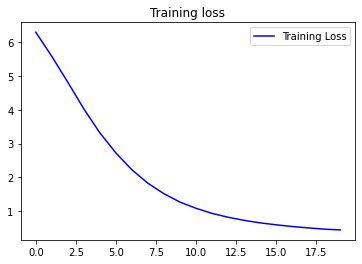

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [13]:
seed_text = "که ایران چو باغی ست خرم بهار"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

که ایران چو باغی ست خرم بهار داد پاسخ چنین گفت ای سرافراز شاه به ایوانش یاقوت برده بکار ز پیروزه کرده برو بر نگار همه ساله روشن بهاران بدی گلان چون رخ غمگساران بدی ز درد و غم و رنج دل دور بود بدی را تن دیو رنجور بود به خواب اندر آمد ز من زبان انجمن وگر بازگردم به نزدیک شاه به طوس سپهبد سپارم سپاه ازو نیز هم بر تنم بد رسد چپ و راست بد بینم و پیش بد نیاید ز سودابه خود جز بدی ندانم چه خواهد رسید ایزدی دو تن را ز لشکر ز کندآوران چو بهرام و چون زنگهٔ شاوران


In [0]:
model.save("word_lstm.h5")